In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

from scipy.signal import medfilt
from scipy.interpolate import interp1d, splev, splrep

import astropy.units as units
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.coordinates import SkyCoord, EarthLocation

In [2]:
c = 299792.458

def doppler_shift(wavelength, flux, dv):
    doppler_factor = np.sqrt((1 - dv/c)/(1 + dv/c))
    new_wavelength = wavelength * doppler_factor
    long_wl = np.concatenate([[np.min(wavelength) - 1], wavelength, [np.max(wavelength) + 1]])
    long_flux = np.concatenate([[1], flux, [1]])
    spl = splrep(long_wl, long_flux)
    new_flux = splev(new_wavelength, spl)
    return new_flux

-75.89999999999719


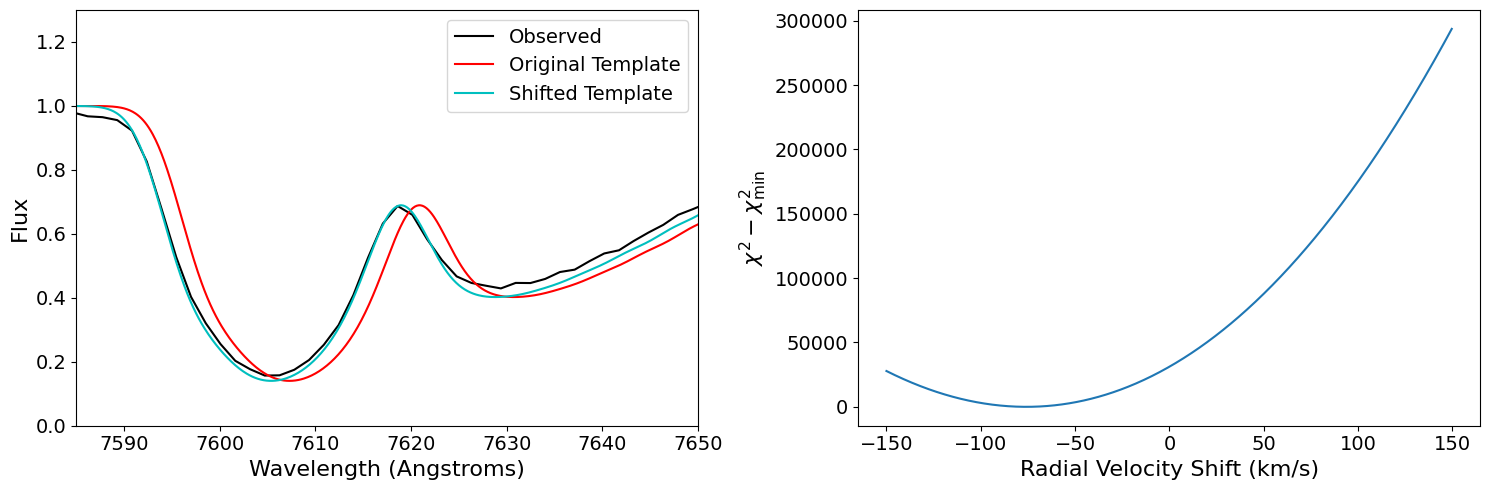

In [3]:
# read in the tellurics 
tmp = np.load('telluric_grid_airmass_r15000.npz')
wl_ref = tmp['wl_grid']
airmass_vals = tmp['airmass_vals']
telluric_grids = tmp['telluric_grids']
tmp.close()

# smooth to resolution of DBSP
FWHM_AA = 6 
sigma_AA = FWHM_AA/2.35
sigma_pix = sigma_AA/np.median(np.diff(wl_ref))
g = Gaussian1DKernel(stddev = sigma_pix)

def flexure_correction(file, plot = False, flex_range = 150):
    
    # Undo heliocentric correction
    hdu = fits.open(file)
    wl, counts, err = hdu[1].data['OPT_WAVE'], hdu[1].data['OPT_COUNTS'], hdu[1].data['OPT_COUNTS_SIG']
    counts = doppler_shift(wl, counts, 299792 * (1 - hdu[1].header['VEL_CORR']))
    err = doppler_shift(wl, err, 299792 * (1 - hdu[1].header['VEL_CORR']))
    this_airmass = hdu[0].header['AIRMASS']

    # Smoothen template spectrum
    ai = min(int(np.round((this_airmass-airmass_vals[0])/(airmass_vals[1]-airmass_vals[0]))), len(airmass_vals)-1)
    flux_ref = telluric_grids[ai]
    flux_smooth = convolve(flux_ref, g, fill_value = np.median(flux_ref))
    
    # Smoothen observed spectrum
    norm_counts = counts/np.median(counts[(wl > 7550) & (wl < 7580)])
    norm_err = err/np.median(counts[(wl > 7550) & (wl < 7580)])
    flux_smooth = flux_smooth/np.median(flux_smooth[(wl_ref > 7550) & (wl_ref < 7580)])
    
    # Use A-band of molecular oxygen to calculate flexure correction based on chi-squared metric
    dvs = np.arange(-flex_range, flex_range, 0.3)
    wl_min, wl_max = 7585, 7650
    chi2s =[]
    for dv in dvs:
        flam_shift = doppler_shift(wl_ref, flux_smooth, dv)
        this_interp = np.interp(wl, wl_ref, flam_shift)
        this_chi = (this_interp - norm_counts)**2 / norm_err**2
        m = (wl > wl_min) & (wl < wl_max)
        chi2s.append(np.sum(this_chi[m]))
    chi2s = np.array(chi2s)
    best_shift = dvs[np.argmin(chi2s)] 
    
    # Plot the flexure correction
    if plot:
        f, ax = plt.subplots(1, 2, figsize = (15, 5))
        ax[0].plot(wl, norm_counts, 'k', label = 'Observed')
        ax[0].plot(wl_ref, flux_smooth, 'r', label = 'Original Template')
        ax[0].plot(wl_ref, doppler_shift(wl_ref, flux_smooth, best_shift), 'c', label = 'Shifted Template')
        ax[0].set_xlim(wl_min, wl_max)
        ax[0].set_ylim(0, 1.3)
        ax[0].set_xlabel('Wavelength (Angstroms)', size = 16)
        ax[0].set_ylabel('Flux', size = 16)
        ax[0].legend(fontsize = 14)
        ax[1].plot(dvs, chi2s - np.min(chi2s))
        ax[1].set_xlabel('Radial Velocity Shift (km/s)', size = 16)
        ax[1].set_ylabel(r'$\chi^2 - \chi^2_{\min}$', size = 16)
        plt.tight_layout()
    return best_shift

corr = flexure_correction('spec1d_red0073-HD40460_DBSPr_20221122T134202.950.fits', plot = True)
print(corr)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  T_EFF   =               5000.0 / Effective Temperature (K)                      LOGG    =                  4.5 / Surface Gravity (log(g))                       MH      =                  0.0 / Metallicity [M/H]                              CM      =                  0.0 / Carbon Abundance [C/M]                         ALPHA   =                  0.0 / alpha Abundance [alpha/M]                      INSBROAD=               2000.0 / Instrumental Broadening (km/s)                 ROTBROAD=                  0.0 / Rotational Broadening (km/s)                   MICROTUR=                 20.0 / Microturbulence (km/s)                         END                                     

,Wavelength,SpecificIntensity,Continuum
0,1000.0021,4.319300e-08,7.217000e-08
1,1000.2521,7.405900e-08,1.269900e-07
2,1000.5023,7.971900e-08,1.435700e-07
3,1000.7524,7.685200e-08,1.459400e-07
4,1001.0027,7.601200e-08,1.470800e-07


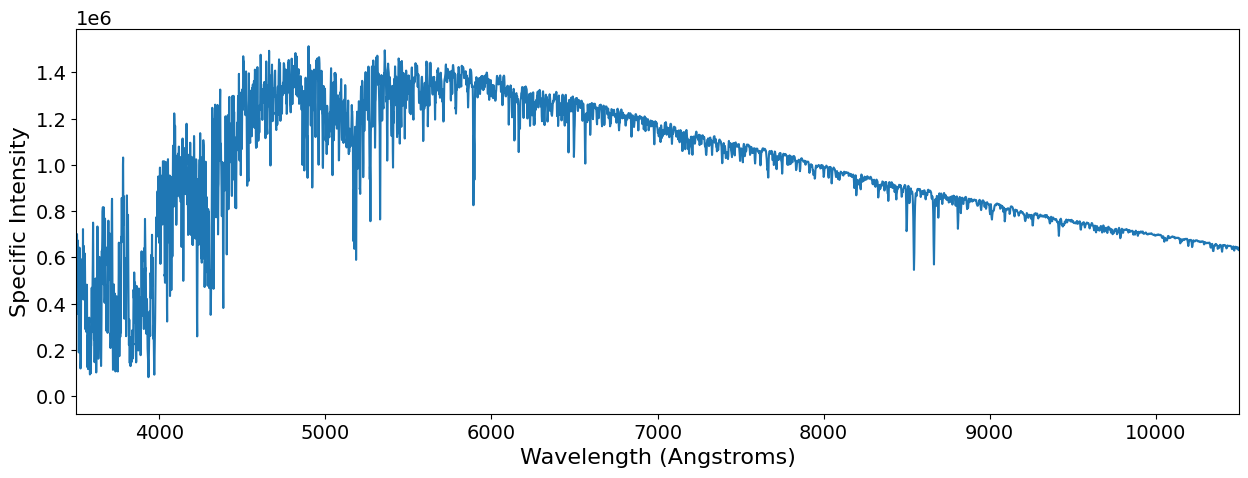

In [4]:
def read_template(template_file, plot = True, ylims = None):
    temp_hdul = fits.open(template_file)
    template_dat = Table.read(template_file, format = 'fits')
    template_tab = template_dat.to_pandas()
    
    if plot:
        print(temp_hdul[0].header)
        display(template_tab.head())

        plt.figure(figsize = (15, 5))
        plt.plot(template_tab['Wavelength'].values, template_tab['SpecificIntensity'].values)
        plt.xlabel('Wavelength (Angstroms)', fontsize = 16)
        plt.ylabel('Specific Intensity', fontsize = 16)
        plt.xlim(3500, 10500)
        if ylims is not None:
            plt.ylim(*ylims)
        plt.show();
        
    temp_hdul.close()
    return template_tab

# BOSZ Kurucz template spectrum downloaded from STSCI archive
template = read_template('amp00cp00op00t5000g45v20modrt0b2000rs.fits')

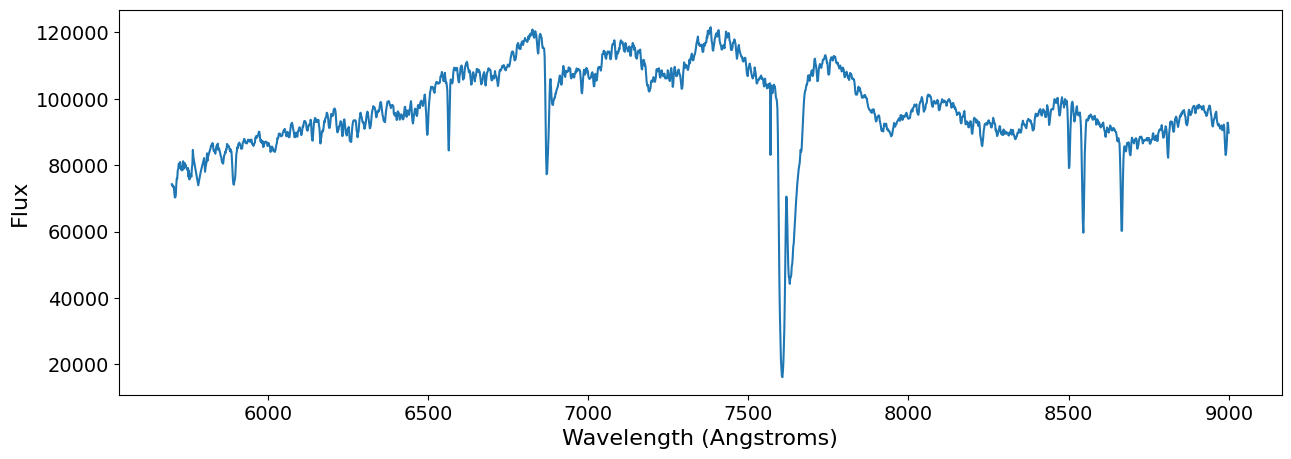

In [5]:
def find_correct_index(file):
    temp = fits.open(file)
    closest = 999
    correct_index = -1
    for j in range(1, len(temp) - 1):
        pos = int(temp[j].name.split('-')[0][-4:])
        dist = abs(pos - 150)
        if dist < closest:
            correct_index = j
            closest = dist
    temp.close()
    return correct_index


def read_dbsp(file, low = 5700, high = 9000, plot = True):
    correct_index = find_correct_index(file)
    
    red_tab = Table.read(file, format = 'fits', hdu = correct_index).to_pandas()
    red_filt = red_tab[red_tab['OPT_MASK'].values.astype(bool)]
    red_lim = red_filt[(red_filt['OPT_WAVE'] >= low) & (red_filt['OPT_WAVE'] <= high)]
    red_cut = red_lim.copy()[['OPT_WAVE', 'OPT_COUNTS']]
    red_cut['Flux Uncertainty'] = np.sqrt(1 / red_lim['OPT_COUNTS_IVAR'].values)

    spectrum = red_cut.rename({'OPT_WAVE' : 'Wavelength', 'OPT_COUNTS' : 'Flux'}, axis = 1)
    if plot:
        plt.figure(figsize = (15, 5))
        plt.plot(spectrum['Wavelength'], spectrum['Flux'])
        plt.xlabel('Wavelength (Angstroms)', fontsize = 16)
        plt.ylabel('Flux', fontsize = 16)
    return spectrum

# Observation of RV standard star HD 40460
observation = read_dbsp('spec1d_red0073-HD40460_DBSPr_20221122T134202.950.fits')

In [6]:
def medfilt_fixed_window_AA(wl, flam, window_AA = 301):
    wl_grid = np.arange(np.min(wl), np.max(wl), 1)
    flam_interp = np.interp(wl_grid, wl, flam)
    cont_interp = medfilt(flam_interp, window_AA)
    cont = np.interp(wl, wl_grid, cont_interp)
    return cont

In [7]:
def radial_velocity(observation, template, lower_bound = 6000, upper_bound = 6800, kernel = 301, 
                    threshold = 1.2, rv_range = 250, plot = True, printout = True):
    
    # Wavelength range of interest
    filtered = observation[(observation['Wavelength'] >= lower_bound) & (observation['Wavelength'] <= upper_bound)]
    filtered = filtered.reset_index().drop(['index'], axis = 1)
    
    # Median filter observation and template
    running_median = medfilt_fixed_window_AA(filtered['Wavelength'].values, filtered['Flux'].values, 
                                             window_AA = kernel)
    continuum = medfilt_fixed_window_AA(template['Wavelength'].values, template['SpecificIntensity'].values, 
                                        window_AA = kernel)
    
    normalized_observation = filtered['Flux'].values / running_median
    flux_norm_err = filtered['Flux Uncertainty'].values / running_median
    
    # Compute best-fit radial velocity shift based on chi-squared metric
    shifts = np.linspace(-rv_range, rv_range, 100)
    chi2s = []
    for shift in shifts:
        shifted_template = doppler_shift(template['Wavelength'].values, template['SpecificIntensity'].values, shift)
        normalized_template = np.interp(filtered['Wavelength'].values, template['Wavelength'].values, 
                                        shifted_template / continuum)
        chi2 = (normalized_template - normalized_observation) ** 2 / (flux_norm_err ** 2)
        chi2s.append(np.sum([c for c, n in zip(chi2, normalized_observation) if n <= threshold]))
    min_chi2 = np.min(chi2s)
    chi2s = np.array(chi2s) - min_chi2
    
    best_shift_chi2 = shifts[np.argmin(chi2s)]
    if printout:
        print('Radial Velocity (Chi-Squared):', np.rint(best_shift_chi2), 'km/s')    
    if plot:
        plt.figure(figsize = (15, 5))
        plt.plot(shifts, chi2s)
        plt.xlabel('Radial Velocity (km/s)', fontsize = 16)
        plt.ylabel('Chi-Squared', fontsize = 16)
        plt.show();
    return best_shift_chi2

In [8]:
def convert_to_hjd(mjd_utc, ra, dec, site = 'palomar'):
    '''
    convert from local to hjd times (all UTC)
    '''
    jd_utc = mjd_utc + 2400000.5
    
    loc = EarthLocation.of_site(site)
    time_inp = Time(jd_utc, format='jd', scale='utc', location=loc)

    target = SkyCoord(ra, dec, unit=(units.deg, units.deg), frame='icrs')
    ltt_helio = time_inp.light_travel_time(target, 'heliocentric')
    hjd_utc = jd_utc + ltt_helio
    
    hjd_utc = Time(str(hjd_utc), format='jd', scale='utc', location=loc)
    return hjd_utc


def extract_time_DBSP(file):
    hdul = fits.open(file)
    ra, dec = hdul[0].header['RA'], hdul[0].header['DEC']
    mjd_mid_utc = hdul[0].header['MJD'] + hdul[0].header['EXPTIME']/3600/24/2
    hjd_utc = convert_to_hjd(mjd_utc = mjd_mid_utc, ra = ra, dec = dec, site = 'palomar')
    hjd_utc.format = 'iso'
    hdul.close()
    return hjd_utc.value

Radial Velocity (Chi-Squared): 33.0 km/s


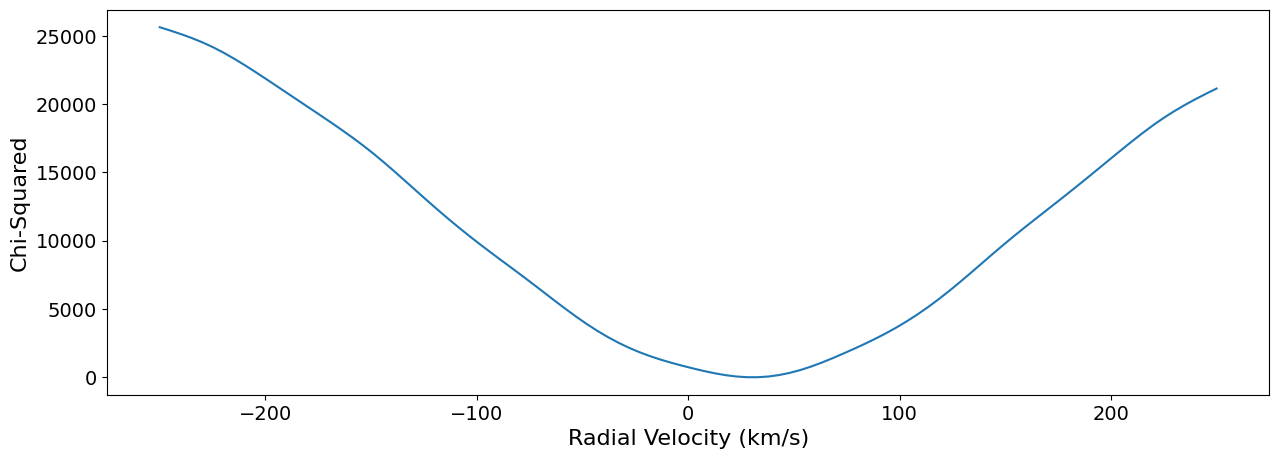

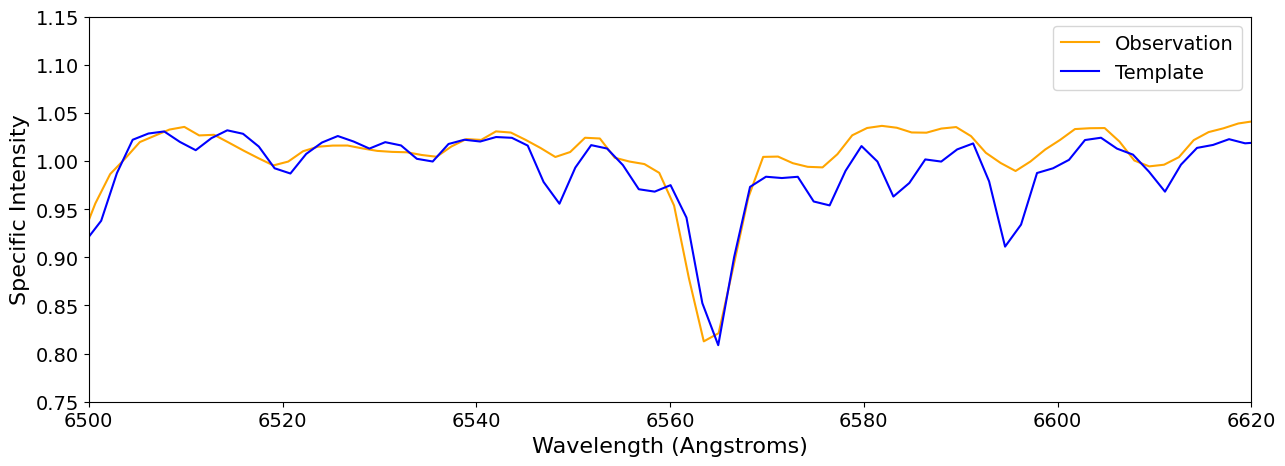

Manual Correction:  -76.0 km/s
Observation Time: 2022-11-22 13:49:08.873
Radial Velocity: (109.0 +/- 10) km/s


In [9]:
def overlay_spectra(observation, template, rv, low_lim = 6500, high_lim = 6620, kernel = 301):
    new_obs_flux = doppler_shift(observation['Wavelength'].values, observation['Flux'].values, -rv)
    new_continuum = medfilt_fixed_window_AA(observation['Wavelength'].values, observation['Flux'].values, 
                                            window_AA = kernel)
    new_flux = new_obs_flux / new_continuum
    
    temp_continuum = medfilt_fixed_window_AA(template['Wavelength'].values, template['SpecificIntensity'].values, 
                                             window_AA = kernel)
    temp_flux = template['SpecificIntensity'].values / temp_continuum

    ovfig = plt.figure(figsize = (15, 5))
    plt.plot(observation['Wavelength'].values, new_flux, color = 'orange', label = 'Observation')
    plt.plot(template['Wavelength'].values, temp_flux, color = 'blue', label = 'Template')
    plt.xlabel('Wavelength (Angstroms)', fontsize = 16)
    plt.ylabel('Specific Intensity', fontsize = 16)
    plt.xlim(low_lim, high_lim)
    plt.ylim(0.75, 1.15)
    plt.legend(fontsize = 14)
    plt.show();
    return ovfig
    

def rv_pipeline(observation, template, flexure_file, low_bound = 6000, high_bound = 6600, kernel = 301, 
                plot = True, overlay = True, flexure = True):
    time = extract_time_DBSP(flexure_file)
    rv = radial_velocity(observation, template, lower_bound = low_bound, upper_bound = high_bound,
                         kernel = kernel, plot = plot)
    if overlay:
        ovfig = overlay_spectra(observation, template, rv, kernel = kernel)
    if flexure:
        manual_correction = flexure_correction(flexure_file)
        print('Manual Correction: ', np.rint(manual_correction), 'km/s')
        rv = rv - manual_correction
    return time, rv

# Matches literature value of 100 km/s
time, rv = rv_pipeline(observation, template, 'spec1d_red0073-HD40460_DBSPr_20221122T134202.950.fits')
print('Observation Time:', time)
print('Radial Velocity: (' + str(np.rint(rv)) + ' +/- 10) km/s')